# NYC Shelter Demand Analysis

## Problem Statement

The goal of this analysis is to explore patterns in NYC shelter populations 
and their relationship with environmental and economic factors. 

Objectives:

- Analyze trends in total shelter populations over time.
- Examine the relationship between shelter populations and minimum daily 
  temperature.
- Investigate how unemployment rates, reported monthly, correlate with shelter usage.

The focus is on **exploratory data analysis (EDA)** rather than predictive modeling.







### 1. Data Loading and Initial Preparation

Three datasets are used in this analysis:

- NYC DHS daily report
- NOAA daily minimum temperature data (Central Park)
- NYC unemployment rate data reported at a monthly frequency

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path_dhs = "DHS_Daily_Report_20251022.csv"
file_path_weather = "4157850.csv"
file_path_unemployement = "NYUR.csv"

# Loading all 3 datasets
dhs_data = pd.read_csv(file_path_dhs)
weather_data = pd.read_csv(file_path_weather)
unemployement_data = pd.read_csv(file_path_unemployement, header=None)

# Column names were added to the unemployment dataset, which lacked metadata.
unemployement_data.columns = ['Date', 'Unemployment Rate']

### 2. Date Standardization

The `Date` column serves as the primary key for merging these datasets. To ensure a successful join, I standardized the naming and converted the data type to `datetime` format across all dataframes.

In [18]:
# Rename and convert to datetime
def formatDate(df):
    for cols in df.columns:
        if 'date' in cols.lower() or 'date of census' in cols.lower():
            df = df.rename(columns = {cols : 'Date'})
            df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, format='mixed')
            return df
    return df

dhs_data = formatDate(dhs_data)
weather_data = formatDate(weather_data)
unemployement_data = formatDate(unemployement_data)

### 3. Data Integration
The unemployment dataset is reported monthly, but the other data is daily. So created a `Year_Month` column to act as a bridge. This lets me attach the monthly unemployment rate to every day in that month without losing any daily weather or shelter information.


In [20]:
# Create the bridge key
unemployement_data['Year_Month'] = unemployement_data['Date'].dt.to_period('M')
dhs_data['Year_Month'] = dhs_data['Date'].dt.to_period('M')

# Merge DHS data with Unemployment data
df = pd.merge(
    dhs_data,
    unemployement_data[['Year_Month', 'Unemployment Rate']],
    on='Year_Month',
    how='left'
)

# Merge with Weather data
df_final = pd.merge(
    df,
    weather_data[['Date', 'TMIN']],
    on='Date',
    how='left'
)

### 4. Handling Missing Data
After merging, I identified missing values in the Unemployment Rate column for the most recent dates.
This is due to a reporting lag, where economic data is released slower than daily shelter counts. 
I removed these rows to ensure the dataset remains consistent for analysis.

In [22]:
# Check counts before cleaning (shows the 51 missing values)
df_final.info()

# Remove incomplete rows
df_final = df_final.dropna(subset=['Unemployment Rate'])

# Confirm the data is now balanced
print(f"New dataset shape: {df_final.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696 entries, 0 to 1695
Data columns (total 16 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   Date                                                     1696 non-null   datetime64[ns]
 1   Total Adults in Shelter                                  1696 non-null   int64         
 2   Total Children in Shelter                                1696 non-null   int64         
 3   Total Individuals in Shelter                             1696 non-null   int64         
 4   Single Adult Men in Shelter                              1696 non-null   int64         
 5   Single Adult Women in Shelter                            1696 non-null   int64         
 6   Total Single Adults in Shelter                           1696 non-null   int64         
 7   Families with Children in Shelter                  


### 5. Final Feature Selection and Note on Outliers

**Selected Features:**  
- Date  
- Shelter Population  
- Unemployment Rate  
- Temperature  

**Note on Outliers:**  
I have intentionally kept all data points, including unusual "outliers" from the COVID-19 period. Since this is an Exploratory Data Analysis (EDA) rather than a predictive model, these values represent real-world history rather than errors. Preserving them "as-is" ensures an honest look at how the pandemic impacted NYC’s social services.

In [24]:
# Selecting core columns for analysis
cols_to_keep = [
    'Date',
    'Total Individuals in Shelter',
    'Unemployment Rate',
    'TMIN'
]

df_reduced = df_final[cols_to_keep]

# Renaming for better readability
df_reduced = df_reduced.rename(columns = {'TMIN':'Minimum Temperature'})

## 6. Statistical Summary with Histogram
I used the `.describe()` method to get a quick overview of the data. This helps me interpret the distribution and range of my variables

I visualized the distribution of each column using histograms. This helps verify the skewness and patterns identified in the statistical summary.

       Total Individuals in Shelter  Unemployment Rate  Minimum Temperature
count                       1645.00            1645.00              1645.00
mean                       70051.05               4.68                51.03
std                        17861.16               1.11                15.69
min                        44586.00               3.80                 3.00
25%                        48199.00               4.00                39.00
50%                        80647.00               4.20                51.00
75%                        86340.00               4.50                65.00
max                        89558.00               8.10                81.00


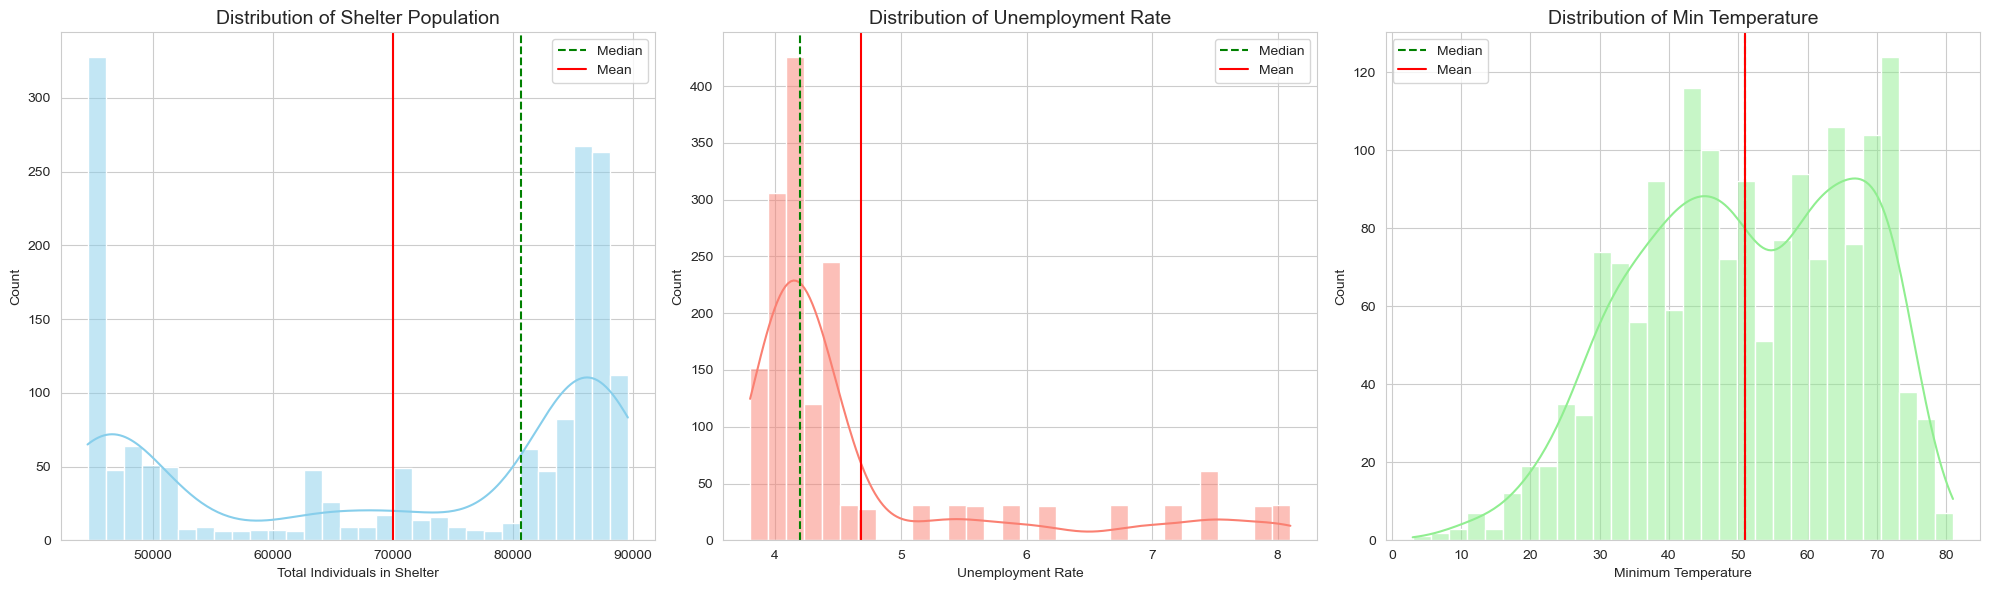

In [26]:
# Statistical summary
stat_sum = df_reduced[['Total Individuals in Shelter', 'Unemployment Rate', 'Minimum Temperature']].describe().round(2)

# Set the visual style
sns.set_style("whitegrid")

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Total Individuals in Shelter (Left-Skewed)
sns.histplot(df_reduced['Total Individuals in Shelter'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(df_reduced['Total Individuals in Shelter'].median(), color='green', linestyle='--', label='Median')
axes[0].axvline(df_reduced['Total Individuals in Shelter'].mean(), color='red', linestyle='-', label='Mean')
axes[0].set_title('Distribution of Shelter Population', fontsize=14)
axes[0].legend()

# 2. Unemployment Rate (Right-Skewed)
sns.histplot(df_reduced['Unemployment Rate'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].axvline(df_reduced['Unemployment Rate'].median(), color='green', linestyle='--', label='Median')
axes[1].axvline(df_reduced['Unemployment Rate'].mean(), color='red', linestyle='-', label='Mean')
axes[1].set_title('Distribution of Unemployment Rate', fontsize=14)
axes[1].legend()

# 3. Minimum Temperature (Normal Distribution)
sns.histplot(df_reduced['Minimum Temperature'], bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].axvline(df_reduced['Minimum Temperature'].median(), color='green', linestyle='--', label='Median')
axes[2].axvline(df_reduced['Minimum Temperature'].mean(), color='red', linestyle='-', label='Mean')
axes[2].set_title('Distribution of Min Temperature', fontsize=14)
axes[2].legend()

print(stat_sum)
plt.tight_layout()
plt.show()

#### Observations:

- <u>**Total Individuals in Shelter**</u> : The number of people in shelters ranges from **44,586 to 89,558**. While the math says it is left-skewed (because the mean is lower than the median), The histogram shows two distinct clusters (**bimodal**), showing that the population jumped from a low "old normal" to a high "new normal."

- <u>**Unemployment Rate**</u> : The rate goes from **3.8%** to **8.1%**, with a **mean of 4.68%**. Since the mean is closer to the minimum and the histogram shows it is **right-skewed**.

- <u>**Minimum Temperature**</u> : The minimum temperatures range from **3°F to 81°F**, with a **mean of 51.03°F**. While the mean suggests a balanced center, the histogram shows a nearly **bimodal distribution**. There are two distinct peaks representing NYC's cold winters and warm summers, with fewer days falling exactly at the average.

### 7. Correlation Heatmap:

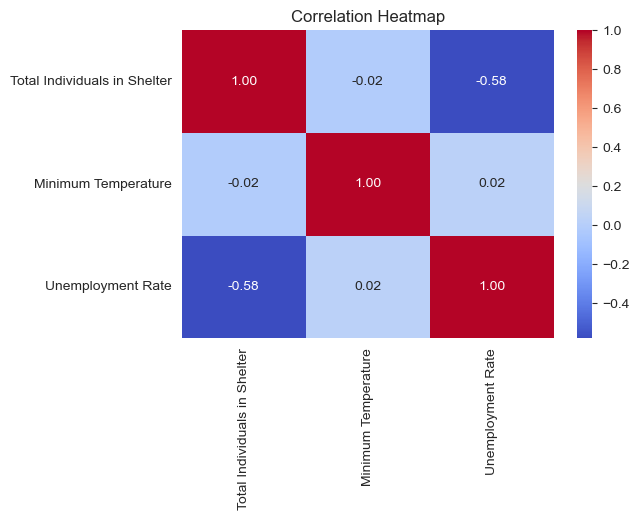

In [29]:
plt.figure(figsize=(6,4))
sns.heatmap(df_reduced[['Total Individuals in Shelter','Minimum Temperature','Unemployment Rate']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### Observations:
- <u> **Shelter Population vs. Unemployment Rate (-0.58):** </u>: There is a strong negative correlation, meaning shelter demand increased while unemployment decreased. This is unusual and likely suggests a time lag (homelessness often happens months after job loss) or the impact of the migrant crisis, where a new population entered the shelter system but was not reflected in official employment stats.
- <u> **Shelter Population vs. Minimum Temperature (-0.02)** </u>: The correlation is close to zero, suggesting no relationship. At first glance, the near-zero correlation may seem surprising, since extreme weather can increase short-term shelter use. However, total shelter population is primarily driven by long-term housing and policy factors rather than daily temperature changes.

**Note:** Since correlation only measures straight-line relationships, these variables will be explored further using scatter plots and time-series charts to uncover the true patterns.

### 8. Time-Series Trend Analysis

To understand the shifts in the data, I plotted each variable over the entire timeline. This helps visualize the "history" behind the distributions we saw earlier.

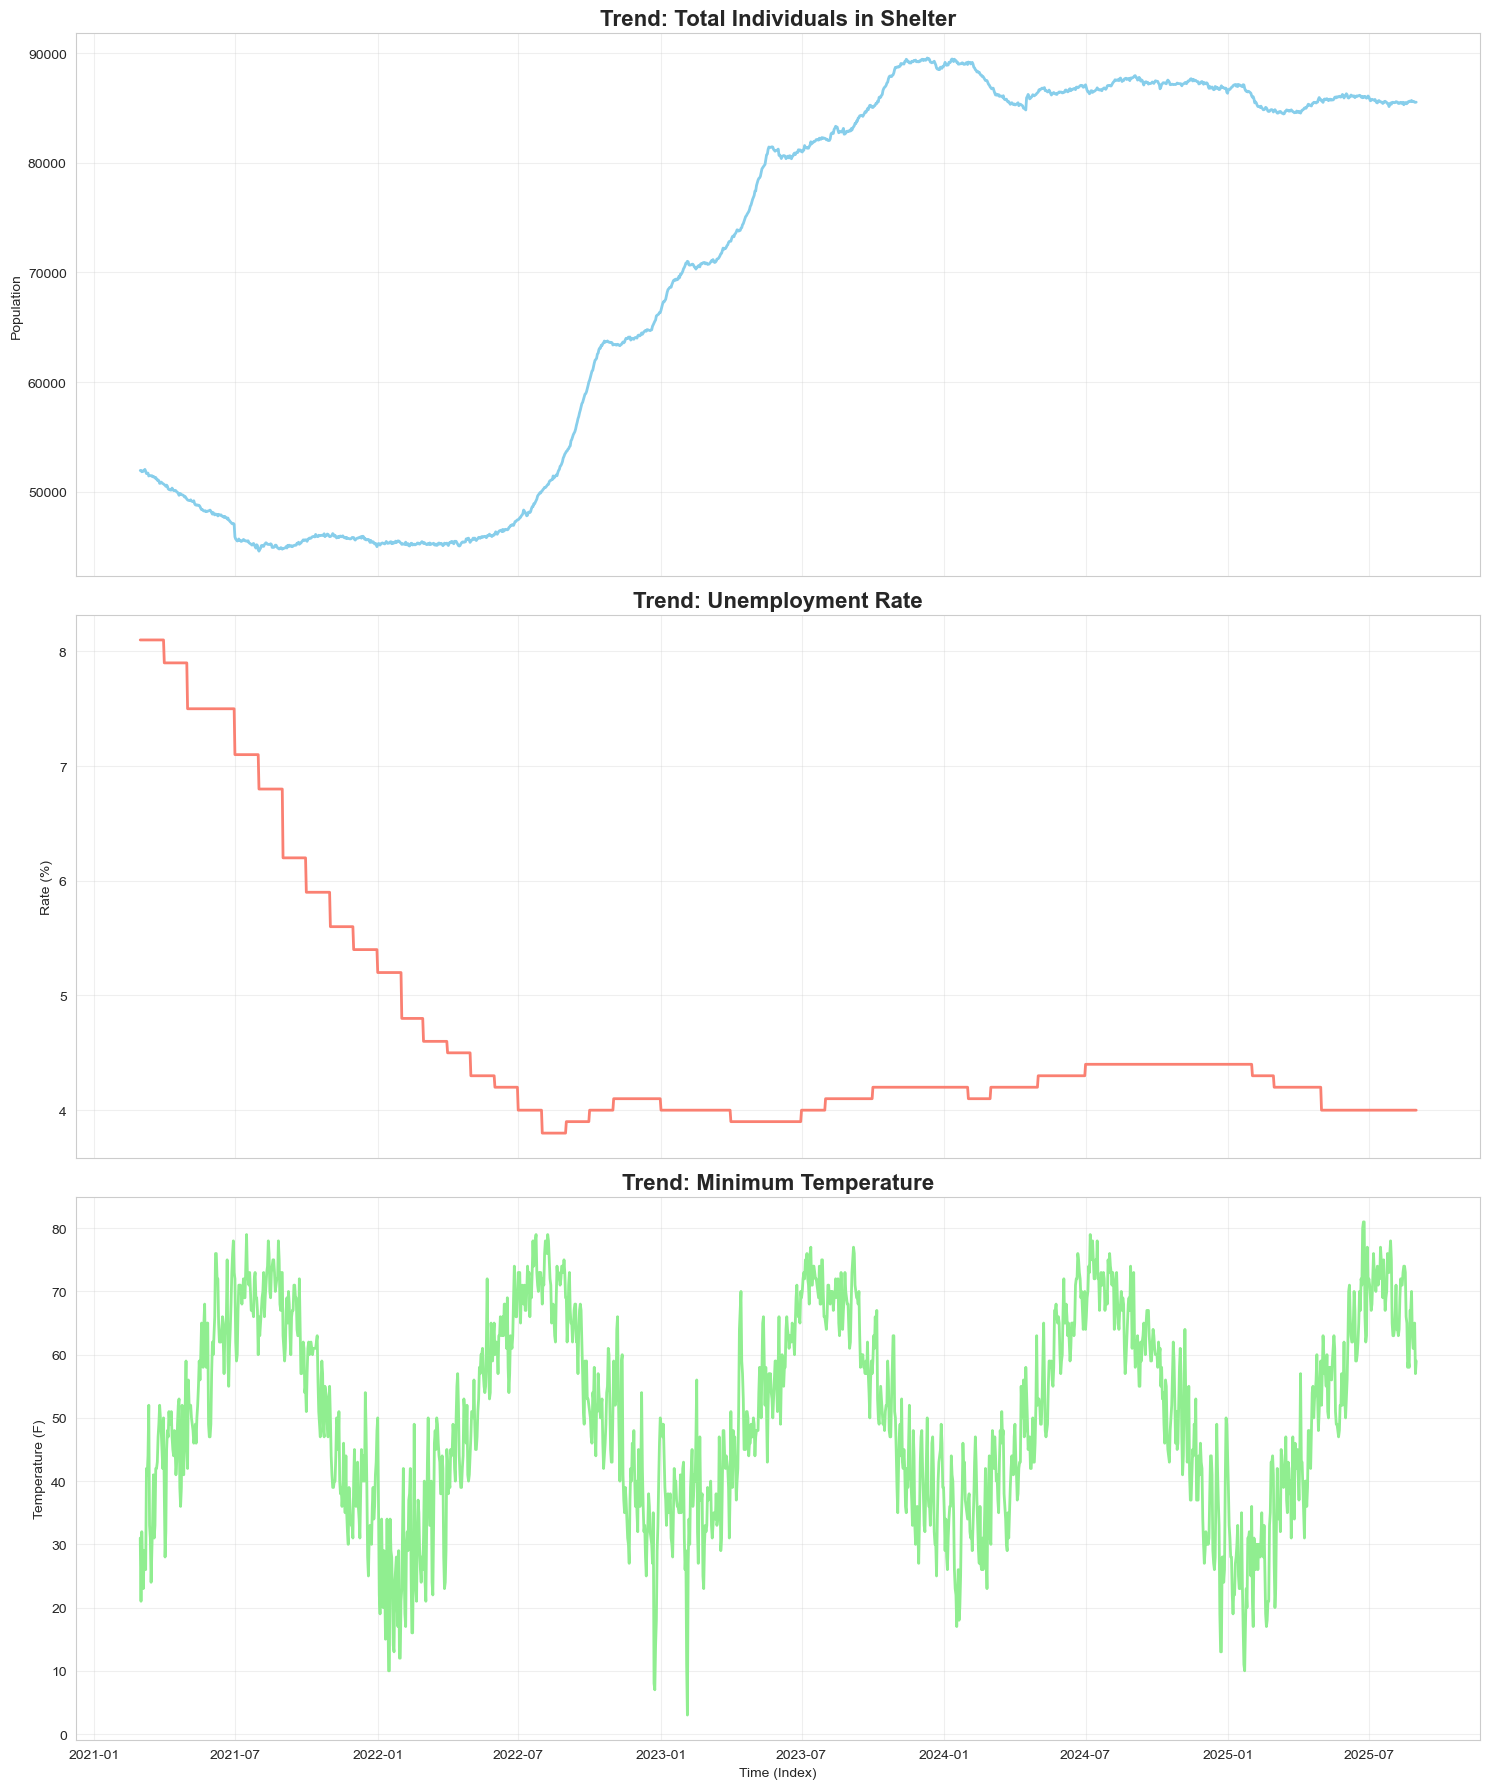

In [32]:
# Make the Date the "label" for the rows
df_reduced['Date'] = pd.to_datetime(df_reduced['Date'])
df_reduced.set_index('Date', inplace=True)

# Create a figure with three vertical subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

# 1. Shelter Trend (The "Structural Shift")
axes[0].plot(df_reduced.index, df_reduced['Total Individuals in Shelter'], color='skyblue', linewidth=2)
axes[0].set_title('Trend: Total Individuals in Shelter', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Population')
axes[0].grid(True, alpha=0.3)

# 2. Unemployment Trend (The "Economic Shock")
axes[1].plot(df_reduced.index, df_reduced['Unemployment Rate'], color='salmon', linewidth=2)
axes[1].set_title('Trend: Unemployment Rate', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Rate (%)')
axes[1].grid(True, alpha=0.3)

# 3. Temperature Trend (The "Seasonal Cycle")
axes[2].plot(df_reduced.index, df_reduced['Minimum Temperature'], color='lightgreen', linewidth=2)
axes[2].set_title('Trend: Minimum Temperature', fontsize=16, fontweight='bold')
axes[2].set_ylabel('Temperature (F)')
axes[2].grid(True, alpha=0.3)


plt.xlabel('Time (Index)')
plt.tight_layout()
plt.show()

#### Observation:
- **Total Individuals in Shelter** shows a sharp, permanent structural shift starting mid-timeline, moving from a stable base of ~45,000 to over ~85,000.
- **Unemployment Rate** highlights a massive spike at the beginning of the period (~ 8.1%) followed by a long, steady decline to a stable ~4% range.
- **Minimum Temperature** exhibits a perfect, repeating seasonal pattern with summer highs winter lows.  The time series shows increased shelter demand during both extreme cold and extreme heat. These opposing effects **might** cancel out in linear correlation.

### 9. Bivariate Analysis (Scatterplot)

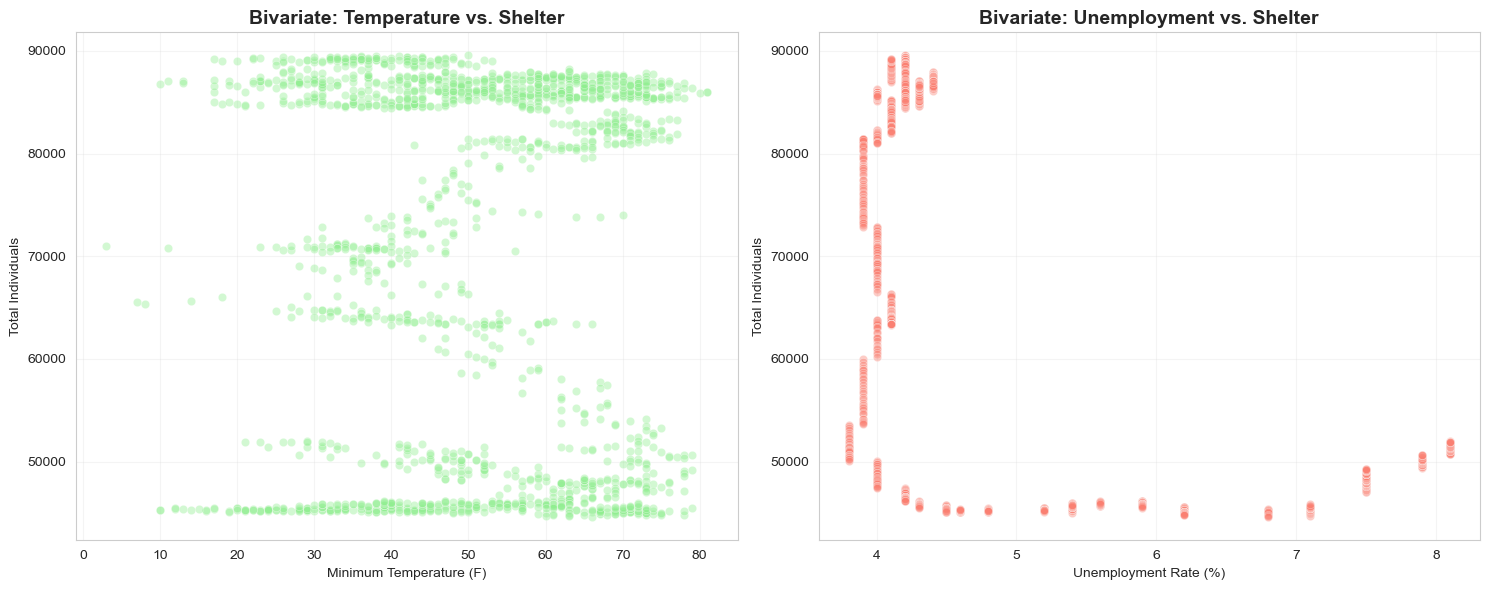

In [35]:
# Create a figure for bivariate analysis
plt.figure(figsize=(15, 6))

# 1. Scatter Plot: Temperature vs. Shelter (The "Smile" / U-Shape)
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_reduced, x='Minimum Temperature', y='Total Individuals in Shelter', alpha=0.4, color='lightgreen')
plt.title('Bivariate: Temperature vs. Shelter', fontsize=14, fontweight='bold')
plt.xlabel('Minimum Temperature (F)')
plt.ylabel('Total Individuals')
plt.grid(True, alpha=0.2)

# 2. Scatter Plot: Unemployment vs. Shelter (The Structural Clusters)
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_reduced, x='Unemployment Rate', y='Total Individuals in Shelter', alpha=0.4, color='salmon')
plt.title('Bivariate: Unemployment vs. Shelter', fontsize=14, fontweight='bold')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Total Individuals')
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

#### Obsevation
The correlation math (-0.02 for temperature and −0.58 for unemployment) was confusing at first, but these charts show exactly why those numbers appeared. They reveal that these variables are non-linear.
- **Shelter Population vs Minimum Temperature**: When we compare minimum temperature to daily shelter population, there isn’t a clear consistent trend where colder temperatures always mean higher shelter demand or vice versa. If there were a strong temperature-dependent effect, we might expect a smooth U-shaped pattern. But this is not observed. Instead, the shelter population increased after the pandemic and remained at a higher “new normal” level due to policy and housing factors, making daily weather changes have little effect on overall shelter demand.
- **Shelter Population vs Unemployement Rate**: During the COVID-19 period, unemployment was high, but eviction moratoria and rental protections prevented many households from losing housing, keeping shelter demand relatively low. After the economy began to recover and unemployment declined, these protections expired, evictions resumed, and shelter demand increased sharply. This timing creates an unusual negative correlation between unemployment and shelter demand that reflects policy changes rather than a direct causal relationship.

### Conclusion

This analysis shows that NYC’s shelter population changed sharply after the COVID-19 period and has remained at a much higher level than before. While factors like unemployment and weather may influence shelter use in the short term, the overall demand appears to be driven mainly by long-term housing and policy changes. As a result, high shelter usage has become the new normal rather than a temporary spike.